#### Working notebook for grid level linear regression relationship between P-E-Q and change in soil moisture

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

outdir = 'figures/SM_P_PmE_PmEQ_scatter/'
#out_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/sm_P_PminusE_eqns/'
rootdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

########## Add more when calculated #########
multiweek = [2] #, 6, 8, 12] #np.array([1, 2, 3, 6, 8, 12])
#############################################

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'
fname_PmE = 'PminusE_*_SEA_*.nc'

lat_pt = -37 #-37
lon_pt = 148 #142
sm_thresh_perc = 0.3     # this is the thershold percentile to identify dry soil moisture conditions

for iW in multiweek:
    
    data_dir_PmEQ = rootdir + 'PminusEQ_week'+str(iW)+'/'
    ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':400, 'lon':400}) #, combine='nested', concat_dim='time', chunks={'lat':1,'lon':1})
    
    data_dir_sm = rootdir + 'sm_week'+str(iW)+'/'
    ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':400, 'lon':400})
    ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':400, 'lon':400})
    
    da_PmEQ_pt_temp = ds_PmEQ['PminusEQ'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").load()
    da_sm_init_pt = ds_sm_init['sm'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").load()
    da_sm_diff_pt = ds_sm_diff['sm_diff'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").load()   

    # reassigning the time dimension of PmEQ to match sm exactly
    da_PmEQ_pt = da_PmEQ_pt_temp.assign_coords(time = da_sm_init_pt.time)
    
    ds_sm_perc = xr.open_dataset(rootdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
    da_sm_thresh_pt = ds_sm_perc['sm'].sel(lat = lat_pt, lon = lon_pt, method = "nearest").sel(quantile = sm_thresh_perc).load()
    
    # day of year is not properly assigned in the dataset of percentiles; reassigning
    dayofyear = np.arange(366)+1
    da_sm_thresh_pt = da_sm_thresh_pt.assign_coords(dayofyear = dayofyear)
    
    # get the corresponding thershold for each day in the init sm dataset
    da_sm_init_thresh_pt = da_sm_thresh_pt.sel(dayofyear = da_sm_init_pt['time.dayofyear'])
    
    # index of dry initial soil mositure days with following positive changes in delta soil moisture
    dryInd = [x & y for (x, y) in zip((da_sm_init_pt<=da_sm_init_thresh_pt).values, (da_sm_diff_pt>0).values)]

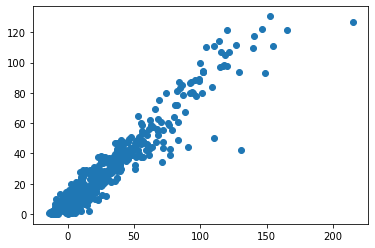

In [25]:
#da_sm_thersh_pt
plt.scatter(da_PmEQ_pt[dryInd].values, da_sm_diff_pt[dryInd].values)

In [28]:
import statsmodels.formula.api as smf
import pandas as pd

df = pd.DataFrame(dict(zip(['PmEQ', 'delSM'], [da_PmEQ_pt[dryInd].values, da_sm_diff_pt[dryInd].values])))

formula = 'delSM ~ PmEQ'
lm = smf.ols(formula, df)
model_lm = lm.fit()
# model_lm.predict(x_new)
# model_lm.params.values
# model_lm.pvalues.values

model_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delSM   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     4817.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):          6.44e-257
Time:                        09:52:48   Log-Likelihood:                -1743.7
No. Observations:                 496   AIC:                             3491.
Df Residuals:                     494   BIC:                             3500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0573      0.498     12.159      0.000       5.078       7.036
PmEQ           0.7459      0.011     69.404      0.000       0.725       0.767
==============================================================================
Omnibus:                      162.177   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1533.359
Skew:                          -1.135   Prob(JB):                         0.00
Kurtosis:                      11.309   Cond. No.                         63.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
model_lm.rsquared_adj

0.9067963834847315

In [37]:
print(model_lm.params)
print(model_lm.conf_int())
print(model_lm.pvalues)


Intercept    6.057301
PmEQ         0.745878
dtype: float64
                  0         1
Intercept  5.078491  7.036110
PmEQ       0.724763  0.766993
Intercept     6.125452e-30
PmEQ         6.440686e-257
dtype: float64


In [82]:
model_lm.conf_int(alpha=0.1)

,0,1
Intercept,5.236330,6.878271
PmEQ,0.728168,0.763588


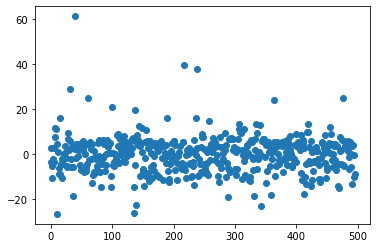

In [42]:
plt.scatter(np.arange(len(da_sm_diff_pt[dryInd].values)), model_lm.fittedvalues.values-da_sm_diff_pt[dryInd].values)

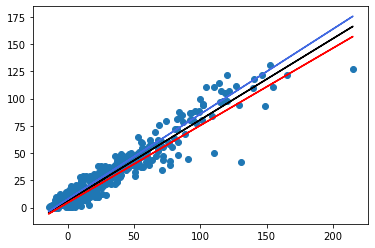

In [60]:
alpha = 0.001

fitted_lower = model_lm.conf_int(alpha=alpha).values[0,0] + model_lm.conf_int(alpha=alpha).values[1,0]*da_PmEQ_pt[dryInd].values
fitted_upper = model_lm.conf_int(alpha=alpha).values[0,1] + model_lm.conf_int(alpha=alpha).values[1,1]*da_PmEQ_pt[dryInd].values

plt.scatter(da_PmEQ_pt[dryInd].values, da_sm_diff_pt[dryInd].values)
plt.plot(da_PmEQ_pt[dryInd].values, model_lm.fittedvalues.values, color="black")
plt.plot(da_PmEQ_pt[dryInd].values, fitted_lower, color="red")
plt.plot(da_PmEQ_pt[dryInd].values, fitted_upper, color="royalblue")


In [84]:
x_new = pd.DataFrame({'PmEQ': np.linspace(20, 200, 21)})
x_new.head()
x_pred = model_lm.predict(x_new)
# x_pred.summary_frame(alpha=0.05)
x_pred

0      20.974863
1      27.687766
2      34.400669
3      41.113572
4      47.826475
5      54.539378
6      61.252281
7      67.965184
8      74.678088
9      81.390991
10     88.103894
11     94.816797
12    101.529700
13    108.242603
14    114.955506
15    121.668409
16    128.381312
17    135.094215
18    141.807118
19    148.520021
20    155.232924
dtype: float64